
# Análisis completo del dataset de enfermedad cardíaca

Este cuaderno presenta un análisis de datos **completo** a partir de los conjuntos de entrenamiento y prueba facilitados. Se sigue un flujo de trabajo estándar en ciencia de datos: desde la inspección inicial y tratamiento de datos hasta la comparación de varios modelos de clasificación y la exploración de algoritmos de clustering. El objetivo principal es maximizar la puntuación **F1** en un problema de clasificación multiclase, a la vez que se extraen conclusiones clínicas de los datos.

La métrica F1 combina precisión y exhaustividad mediante la media armónica; su mejor valor es 1 y el peor es 0. Para calcularla se utilizan los verdaderos positivos, falsos positivos y falsos negativos【512535288017976†L678-L687】.

Se emplean diversos algoritmos supervisados como regresión logística, Naive Bayes, **k‑vecinos más cercanos (KNN)**, máquinas de vectores de soporte (SVM) y métodos de **boosting**. La regresión logística usa la función sigmoide para convertir las salidas en probabilidades y supone independencia de las observaciones y relación lineal entre predictores y logit【345569977973828†L105-L112】【345569977973828†L144-L156】. Naive Bayes aplica el teorema de Bayes con la hipótesis de independencia condicional entre las características【421923170354504†L131-L137】. KNN predice una clase basándose en los **k** ejemplos de entrenamiento más cercanos【294473174916385†L133-L143】. Las SVM son efectivas en espacios de alta dimensión y emplean funciones de núcleo para proyectar datos en espacios no lineales【368212158596170†L133-L148】. Los métodos de boosting combinan varios estimadores de base para mejorar la generalización【31343763836478†L132-L144】.

Como tratamiento del desequilibrio de clases se utiliza una estrategia de sobremuestreo sencilla basada en replicar instancias de la clase minoritaria, similar a la filosofía de SMOTE, técnica que genera ejemplos sintéticos interpolando entre vecinos de la misma clase【872704031669969†L72-L79】【872704031669969†L108-L129】. Para reducir dimensionalidad y explorar la estructura global, se aplica **PCA**【501776467326385†L107-L123】. Para evaluar la colinealidad entre variables se calcula el **factor de inflación de la varianza (VIF)**【231599887232887†L111-L140】【231599887232887†L164-L178】. Para el análisis no supervisado se prueban **K‑means**【276939317679743†L311-L354】 y **DBSCAN**【276939317679743†L895-L931】.


## Importación de librerías y carga de datos

Se importan las librerías necesarias de análisis de datos, visualización y aprendizaje automático. Luego se cargan los archivos `train.csv` y `test.csv`. Para facilitar el análisis se implementa una función de limpieza que convierte las cadenas `'?'` y valores negativos en `NaN`.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

# Load data
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Mia_proyect/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Mia_proyect/test.csv')

# Clean data

def clean_dataframe(df):
    df = df.copy()
    df = df.replace('?', np.nan)
    df = df.applymap(lambda x: np.nan if (isinstance(x, (int, float)) and x < 0) else x)
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = pd.to_numeric(df[col], errors='ignore')
    return df

df_train_clean = clean_dataframe(df_train)
df_test_clean = clean_dataframe(df_test)

print("Primeras filas del conjunto de entrenamiento:")
from IPython.display import display
display(df_train_clean.head())
print("Primeras filas del conjunto de prueba:")
display(df_test_clean.head())


Primeras filas del conjunto de entrenamiento:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label
0,51.0,1.0,1.0,125.0,213.0,0.0,2.0,125.0,1.0,1.4,1.0,1.0,3.0,0
1,54.0,1.0,3.0,120.0,237.0,0.0,0.0,150.0,1.0,1.5,-9.0,-9.0,7.0,2
2,63.0,1.0,4.0,140.0,0.0,NaN,2.0,149.0,0.0,2.0,1.0,NaN,NaN,2
3,52.0,0.0,2.0,140.0,-9.0,0.0,0.0,140.0,0.0,0.0,-9.0,-9.0,-9.0,0
4,55.0,1.0,4.0,140.0,217.0,0.0,0.0,111.0,1.0,5.6,3.0,0.0,7.0,3


Primeras filas del conjunto de prueba:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,57.0,1.0,4.0,156.0,173.0,0.0,2.0,119.0,1.0,3.0,3.0,NaN,NaN
1,52.0,1.0,2.0,160.0,196.0,0.0,0.0,165.0,0.0,0.0,-9.0,-9.0,-9.0
2,48.0,1.0,2.0,100.0,-9.0,0.0,0.0,100.0,0.0,0.0,-9.0,-9.0,-9.0
3,62.0,1.0,4.0,115.0,0.0,NaN,0.0,128.0,1.0,2.5,3.0,NaN,NaN
4,51.0,1.0,3.0,110.0,175.0,0.0,0.0,123.0,0.0,0.6,1.0,0.0,3.0


## 1. Inspección general y tipos de datos

Se explora el número de observaciones y características, y se identifican variables numéricas y categóricas.


In [3]:
print(f"Dimensiones del conjunto de entrenamiento: {df_train_clean.shape}")
print(f"Dimensiones del conjunto de prueba: {df_test_clean.shape}")

from IPython.display import display

display(df_train_clean.describe(include=[np.number]).T)

print("Tipos de datos tras la limpieza:")
print(df_train_clean.dtypes)

numeric_cols = df_train_clean.select_dtypes(include=[np.number]).columns.tolist()
if 'label' in numeric_cols:
    numeric_cols.remove('label')
categorical_cols = [c for c in df_train_clean.columns if c not in numeric_cols + ['label']]

print(f"Variables numéricas: {numeric_cols}")
print(f"Variables categóricas: {categorical_cols}")

Dimensiones del conjunto de entrenamiento: (732, 14)
Dimensiones del conjunto de prueba: (184, 13)


,count,mean,std,min,25%,50%,75%,max
age,732.0,53.364754,9.306868,28.0,47.0,54.0,60.00,76.0
sex,732.0,0.789617,0.407859,0.0,1.0,1.0,1.00,1.0
cp,732.0,3.250000,0.923363,1.0,3.0,4.0,4.00,4.0
trestbps,685.0,131.975182,19.203305,0.0,120.0,130.0,140.00,200.0
chol,727.0,195.357634,113.908130,-9.0,168.0,222.0,267.00,603.0
fbs,674.0,0.059347,1.061011,-9.0,0.0,0.0,0.00,1.0
restecg,732.0,0.602459,0.802966,0.0,0.0,0.0,1.00,2.0
thalach,688.0,138.132267,25.963443,60.0,120.0,140.0,158.25,202.0
exang,688.0,0.386628,0.487331,0.0,0.0,0.0,1.00,1.0
oldpeak,683.0,0.881259,1.112960,-2.6,0.0,0.5,1.55,6.2


Tipos de datos tras la limpieza:
age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
label         int64
dtype: object
Variables numéricas: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Variables categóricas: []


## 2. Valores nulos, duplicados y balance de clases

Se contabilizan valores nulos, duplicados y se revisa el balance de la variable `label`.


Porcentaje de valores nulos en el conjunto de entrenamiento:


,columna,porcentaje_nulos
11,ca,34.016393
12,thal,23.087432
10,slope,12.978142
5,fbs,7.923497
9,oldpeak,6.693989
3,trestbps,6.420765
7,thalach,6.010929
8,exang,6.010929
4,chol,0.683060
0,age,0.000000



Número de registros duplicados: 1
Balance de clases (label):
label
0    327
1    156
2    108
3    107
4     34
Name: count, dtype: int64


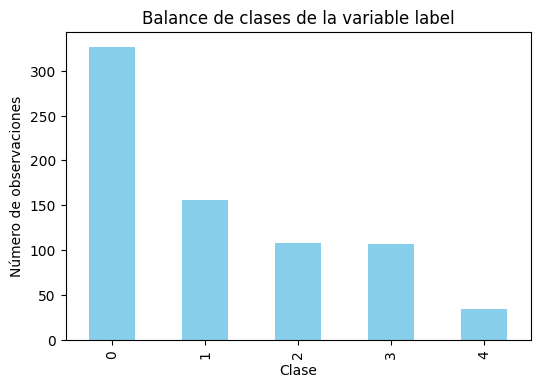

In [4]:
missing_pct = df_train_clean.isnull().mean() * 100
missing_df = pd.DataFrame({'columna': missing_pct.index, 'porcentaje_nulos': missing_pct.values})
missing_df = missing_df.sort_values('porcentaje_nulos', ascending=False)
print("Porcentaje de valores nulos en el conjunto de entrenamiento:")
from IPython.display import display
display(missing_df)

duplicados = df_train_clean.duplicated().sum()
print("")
print(f"Número de registros duplicados: {duplicados}")

class_counts = df_train_clean['label'].value_counts().sort_index()
print("Balance de clases (label):")
print(class_counts)

plt.figure(figsize=(6,4))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Balance de clases de la variable label')
plt.xlabel('Clase')
plt.ylabel('Número de observaciones')
plt.show()

## 3. Distribuciones y detección de valores atípicos

Se examinan las distribuciones de las variables numéricas y se detectan valores atípicos.


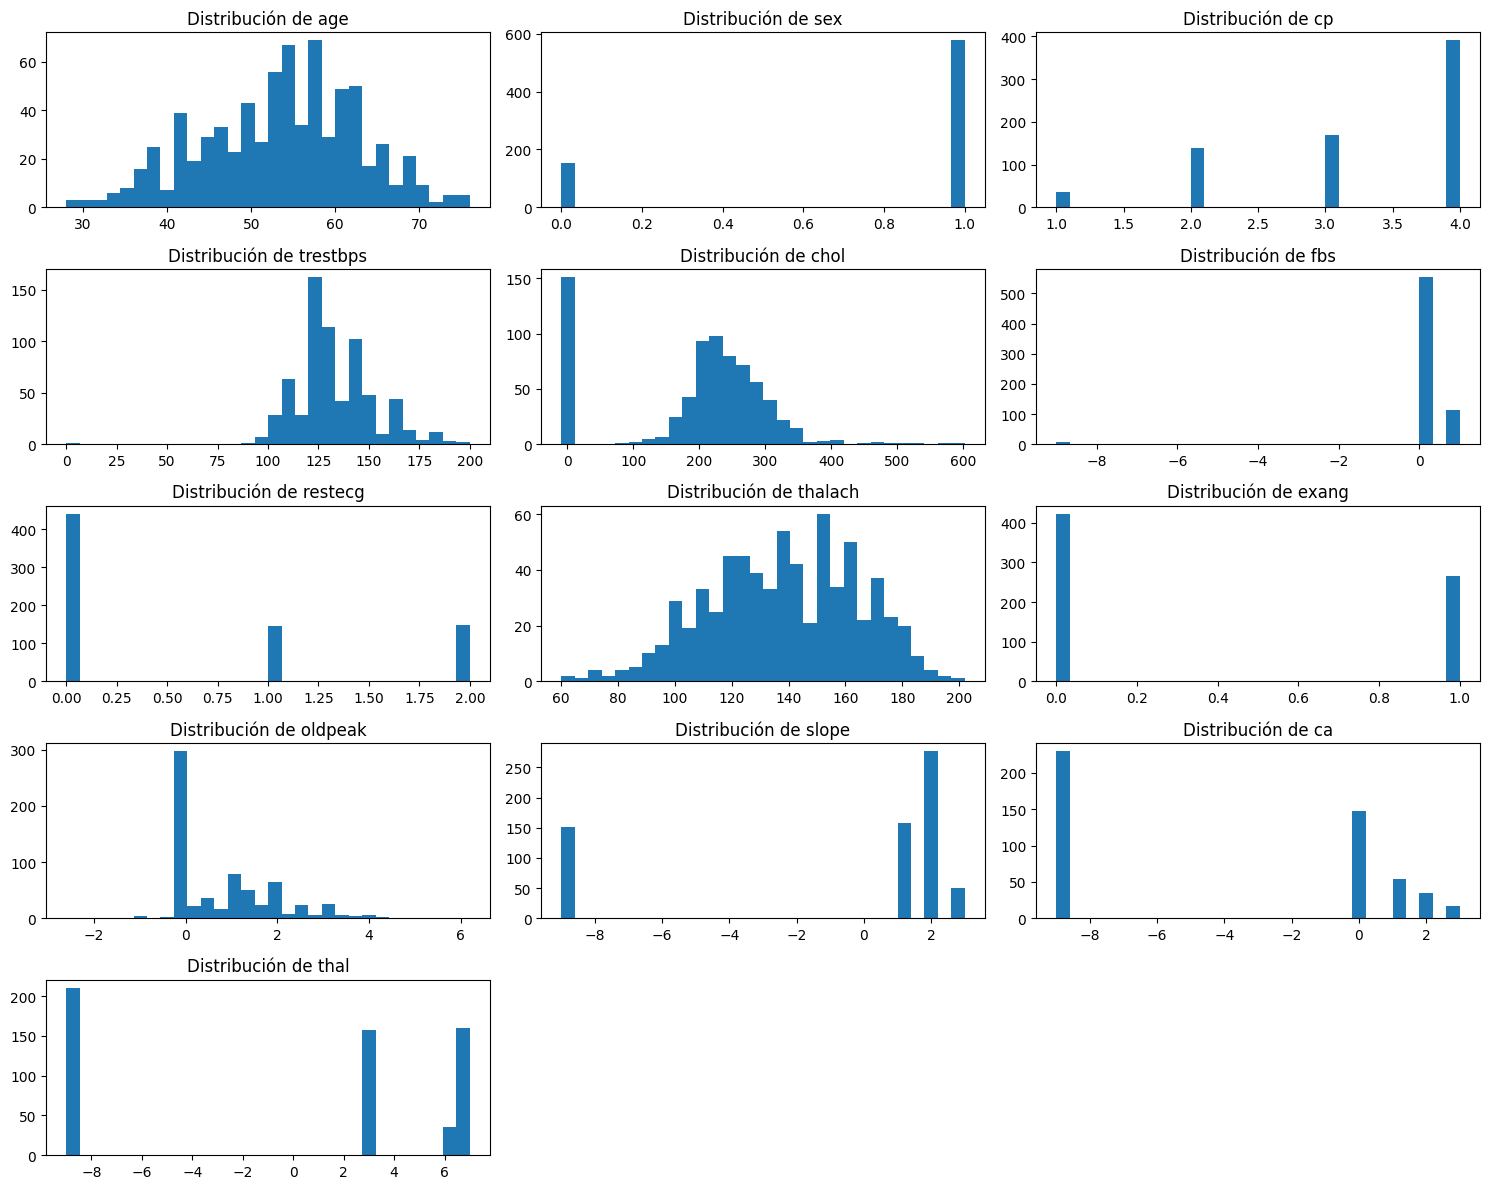

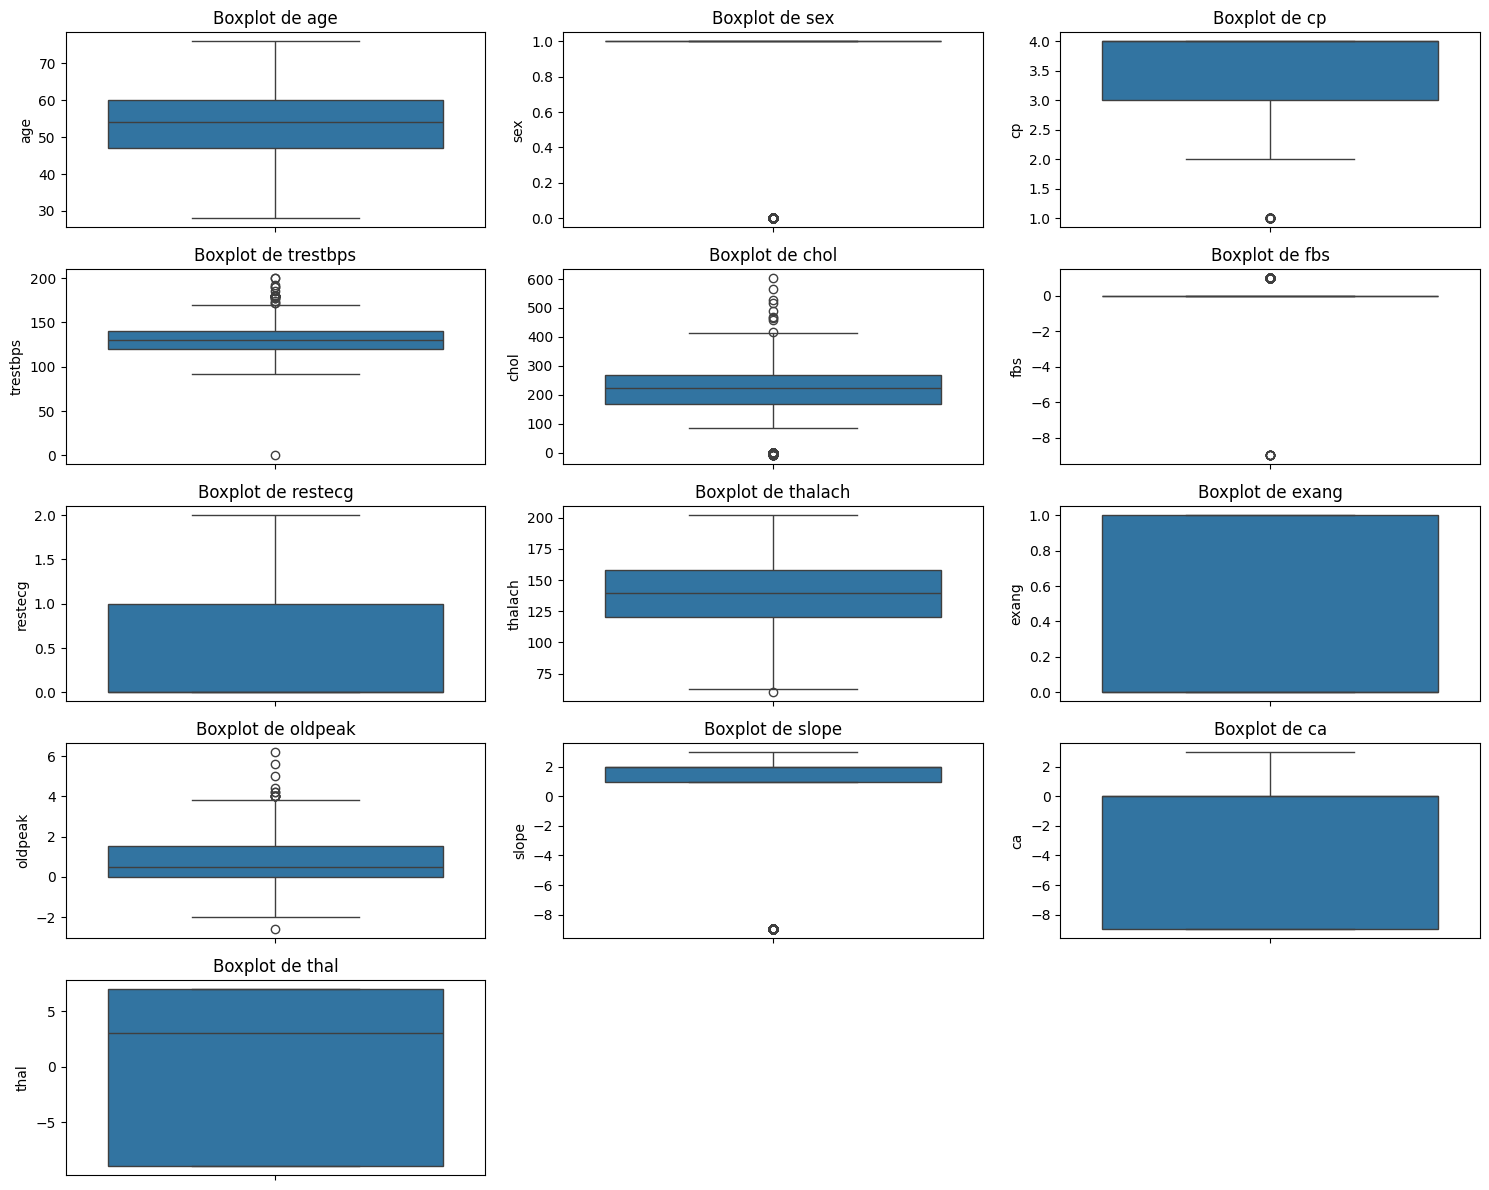

Asimetría y curtosis de las variables numéricas:


,skewness,kurtosis
age,-0.203674,-0.404528
sex,-1.424075,0.028060
cp,-0.881448,-0.435127
trestbps,0.171295,3.381903
chol,-0.535333,-0.060558
fbs,-7.305415,60.836575
restecg,0.840162,-0.935279
thalach,-0.214409,-0.479522
exang,0.466634,-1.787458
oldpeak,1.052054,1.249646


In [5]:
plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot(int(np.ceil(len(numeric_cols)/3)), 3, i+1)
    plt.hist(df_train_clean[col].dropna(), bins=30)
    plt.title(f"Distribución de {col}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot(int(np.ceil(len(numeric_cols)/3)), 3, i+1)
    sns.boxplot(y=df_train_clean[col])
    plt.title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()

skew_kurt = df_train_clean[numeric_cols].skew().to_frame('skewness')
skew_kurt['kurtosis'] = df_train_clean[numeric_cols].kurtosis()
print("Asimetría y curtosis de las variables numéricas:")
from IPython.display import display

display(skew_kurt)

## 4. Correlaciones y multicolinealidad

Se muestra la matriz de correlación y se calcula el VIF.


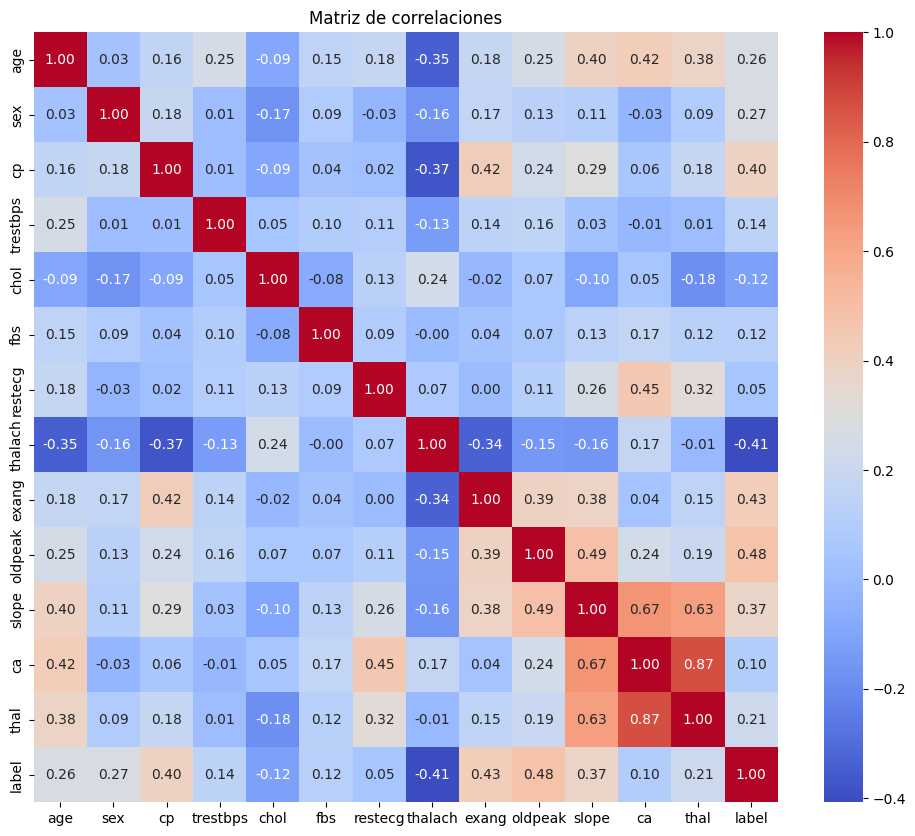

Factor de Inflación de la Varianza (VIF):


,variable,VIF
0,age,37.427970
1,sex,3.542228
2,cp,13.807190
3,trestbps,54.349046
4,chol,11.443788
5,fbs,1.066563
6,restecg,1.931230
7,thalach,25.836063
8,exang,2.465079
9,oldpeak,2.679944


In [6]:

corr_matrix = df_train_clean[numeric_cols + ['label']].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de correlaciones')
plt.show()

from statsmodels.stats.outliers_influence import variance_inflation_factor
X_vif = df_train_clean[numeric_cols].dropna().astype(float)
vif_data = pd.DataFrame()
vif_data['variable'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print("Factor de Inflación de la Varianza (VIF):")
from IPython.display import display

display(vif_data)


## 5. Análisis multivariante y relaciones no lineales

Relaciones entre sexo, edad y la variable `label`, y gráfico LOWESS entre edad y frecuencia cardíaca máxima.


Tabla de contingencia sexo vs label:


label,0,1,2,3,4
sex,,,,,
0.0,115,19,9,8,3
1.0,212,137,99,99,31


Tabla de contingencia edad>50 vs label:


label,0,1,2,3,4
age_gt50,,,,,
0,155,49,20,21,12
1,172,107,88,86,22


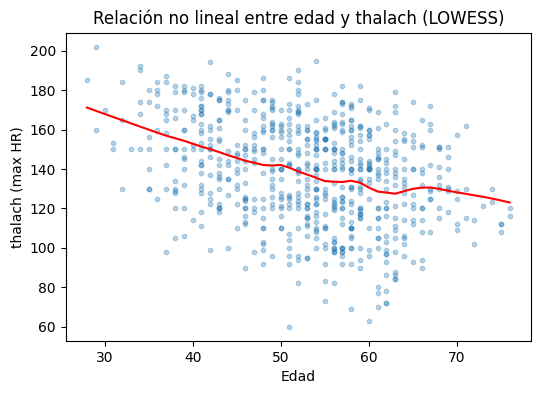

In [7]:

# Variable edad>50
df_train_clean['age_gt50'] = (df_train_clean['age'] > 50).astype(int)

contingency_sex = pd.crosstab(df_train_clean['sex'], df_train_clean['label'])
print("Tabla de contingencia sexo vs label:")
from IPython.display import display

display(contingency_sex)

contingency_age = pd.crosstab(df_train_clean['age_gt50'], df_train_clean['label'])
print("Tabla de contingencia edad>50 vs label:")
display(contingency_age)

import statsmodels.api as sm
plt.figure(figsize=(6,4))
lowess = sm.nonparametric.lowess
lowess_result = lowess(df_train_clean['thalach'].astype(float), df_train_clean['age'].astype(float), frac=0.3)
plt.scatter(df_train_clean['age'], df_train_clean['thalach'], alpha=0.3, s=10)
plt.plot(lowess_result[:,0], lowess_result[:,1], color='red')
plt.xlabel('Edad')
plt.ylabel('thalach (max HR)')
plt.title('Relación no lineal entre edad y thalach (LOWESS)')
plt.show()


## 6. Ingeniería de características y preparación antes de los splits

Se crea la variable `chol_age_ratio` y se define una función de sobremuestreo.


In [8]:
for df in [df_train_clean, df_test_clean]:
    df['chol_age_ratio'] = df['chol'].astype(float) / df['age'].astype(float)
    df['age_gt50'] = (df['age'] > 50).astype(int)

numeric_features = [c for c in df_train_clean.select_dtypes(include=[np.number]).columns if c != 'label']

import numpy as np

def random_oversample(X, y):
    X_resampled = X.copy()
    y_resampled = y.copy()
    unique, counts = np.unique(y, return_counts=True)
    max_count = counts.max()
    for cls in unique:
        idx = np.where(y == cls)[0]
        n_add = max_count - len(idx)
        if n_add > 0:
            add_idx = np.random.choice(idx, size=n_add, replace=True)
            X_resampled = pd.concat([X_resampled, X.iloc[add_idx]], axis=0)
            y_resampled = np.concatenate([y_resampled, y[add_idx]])
    return X_resampled.reset_index(drop=True), y_resampled


## 7. Evaluación de modelos supervisados

Se prueban varios modelos con y sin sobremuestreo y se calcula la F1 macro.


In [9]:

from sklearn.base import clone

def evaluate_models(X, y, models, oversample=False):
    results = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for name, model in models.items():
        f1_scores = []
        for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            if oversample:
                X_train, y_train = random_oversample(X_train, y_train)
            imputer = SimpleImputer(strategy='median')
            scaler = StandardScaler()
            X_train_imp = imputer.fit_transform(X_train)
            X_test_imp = imputer.transform(X_test)
            X_train_scaled = scaler.fit_transform(X_train_imp)
            X_test_scaled = scaler.transform(X_test_imp)
            clf = clone(model)
            clf.fit(X_train_scaled, y_train)
            y_pred = clf.predict(X_test_scaled)
            f1 = f1_score(y_test, y_pred, average='macro')
            f1_scores.append(f1)
        results.append({
            'modelo': name,
            'sobremuestreo': oversample,
            'f1_media': np.mean(f1_scores),
            'f1_std': np.std(f1_scores)
        })
    return pd.DataFrame(results)

X = df_train_clean[numeric_features]
y = df_train_clean['label'].astype(int).values

model_dict = {
    'Regresión logística': LogisticRegression(max_iter=1000, multi_class='auto'),
    'Naive Bayes Gaussiano': GaussianNB(),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'SVM (RBF)': SVC(kernel='rbf', gamma='scale'),
    'Gradient Boosting': GradientBoostingClassifier()
}

eval_no_os = evaluate_models(X, y, model_dict, oversample=False)
eval_os = evaluate_models(X, y, model_dict, oversample=True)

eval_results = pd.concat([eval_no_os, eval_os], ignore_index=True)
print("Resultados de evaluación (F1 macro, media ± std):")
from IPython.display import display

display(eval_results.sort_values('f1_media', ascending=False))


Resultados de evaluación (F1 macro, media ± std):


,modelo,sobremuestreo,f1_media,f1_std
9,Gradient Boosting,True,0.356581,0.035514
4,Gradient Boosting,False,0.343818,0.022010
7,KNN (k=5),True,0.327811,0.032071
5,Regresión logística,True,0.326077,0.050619
0,Regresión logística,False,0.324145,0.037113
8,SVM (RBF),True,0.314389,0.038612
2,KNN (k=5),False,0.314069,0.045176
6,Naive Bayes Gaussiano,True,0.307441,0.023284
1,Naive Bayes Gaussiano,False,0.304263,0.040953
3,SVM (RBF),False,0.292771,0.031390


## 8. Entrenamiento del mejor modelo y predicciones sobre el conjunto de prueba

Se entrena el mejor modelo y se generan predicciones en el conjunto de prueba.


In [10]:

best_row = eval_results.loc[eval_results['f1_media'].idxmax()]
best_model_name = best_row['modelo']
best_oversample = best_row['sobremuestreo']
print(f"Mejor modelo: {best_model_name}, sobremuestreo aplicado: {best_oversample}")

best_model = model_dict[best_model_name]

X_final = df_train_clean[numeric_features]
y_final = df_train_clean['label'].astype(int).values

if best_oversample:
    X_final, y_final = random_oversample(X_final, y_final)

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_final_imp = imputer.fit_transform(X_final)
X_final_scaled = scaler.fit_transform(X_final_imp)

best_model.fit(X_final_scaled, y_final)

X_train_part, X_valid_part, y_train_part, y_valid_part = train_test_split(
    X_final, y_final, test_size=0.2, stratify=y_final, random_state=42)

X_train_part_imp = imputer.fit_transform(X_train_part)
X_valid_part_imp = imputer.transform(X_valid_part)
X_train_part_scaled = scaler.fit_transform(X_train_part_imp)
X_valid_part_scaled = scaler.transform(X_valid_part_imp)

temp_model = clone(best_model)
temp_model.fit(X_train_part_scaled, y_train_part)

valid_pred = temp_model.predict(X_valid_part_scaled)
print("Reporte de clasificación en la partición de validación:")
print(classification_report(y_valid_part, valid_pred))

# Calculate and print the F1 score for the validation set
f1_validation = f1_score(y_valid_part, valid_pred, average='weighted')
print(f"F1 score (ponderado) en la partición de validación: {f1_validation:.2f}")

X_test_matrix = df_test_clean[numeric_features]
X_test_imp = imputer.transform(X_test_matrix)
X_test_scaled = scaler.transform(X_test_imp)
test_pred = best_model.predict(X_test_scaled)

pred_df = df_test_clean.copy()
pred_df['pred_label'] = test_pred
print("Primeras 10 predicciones para el conjunto de prueba:")
from IPython.display import display

display(pred_df[['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','chol_age_ratio','pred_label']].head(10))


Mejor modelo: Gradient Boosting, sobremuestreo aplicado: True
Reporte de clasificación en la partición de validación:
              precision    recall  f1-score   support

           0       0.91      0.77      0.84        66
           1       0.78      0.75      0.77        65
           2       0.72      0.86      0.78        65
           3       0.80      0.74      0.77        66
           4       0.94      1.00      0.97        65

    accuracy                           0.83       327
   macro avg       0.83      0.83      0.83       327
weighted avg       0.83      0.83      0.83       327

F1 score (ponderado) en la partición de validación: 0.83
Primeras 10 predicciones para el conjunto de prueba:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,chol_age_ratio,pred_label
0,57.0,1.0,4.0,156.0,173.0,0.0,2.0,119.0,1.0,3.0,3.0,NaN,NaN,3.035088,4
1,52.0,1.0,2.0,160.0,196.0,0.0,0.0,165.0,0.0,0.0,-9.0,-9.0,-9.0,3.769231,0
2,48.0,1.0,2.0,100.0,-9.0,0.0,0.0,100.0,0.0,0.0,-9.0,-9.0,-9.0,-0.187500,0
3,62.0,1.0,4.0,115.0,0.0,NaN,0.0,128.0,1.0,2.5,3.0,NaN,NaN,0.000000,2
4,51.0,1.0,3.0,110.0,175.0,0.0,0.0,123.0,0.0,0.6,1.0,0.0,3.0,3.431373,0
5,54.0,0.0,3.0,160.0,201.0,0.0,0.0,163.0,0.0,0.0,1.0,1.0,3.0,3.722222,0
6,45.0,1.0,3.0,110.0,0.0,NaN,0.0,138.0,0.0,-0.1,1.0,NaN,NaN,0.000000,0
7,64.0,1.0,4.0,130.0,258.0,1.0,2.0,130.0,0.0,0.0,NaN,NaN,6.0,4.031250,1
8,70.0,1.0,4.0,115.0,0.0,0.0,1.0,92.0,1.0,0.0,2.0,NaN,7.0,0.000000,1
9,32.0,1.0,2.0,125.0,254.0,0.0,0.0,155.0,0.0,0.0,-9.0,-9.0,-9.0,7.937500,0


In [11]:

# 1. Crear el DataFrame de submission
#    - "id": usamos el índice de df_test_clean (0,1,2,...) como identificador
#    - "label": las predicciones del mejor modelo sobre el test
submission = pd.DataFrame({
    "id": df_test_clean.index,        # 👉 si Kaggle pide otro nombre de columna, cámbialo aquí
    "label": test_pred.astype(int)    # 👉 si la columna objetivo se llama distinto, cámbialo también
})

# 2. Guardar el CSV en tu Google Drive (misma carpeta donde tenías train/test)
output_path = "/content/drive/MyDrive/Colab Notebooks/Mia_proyect/submission.csv"
submission.to_csv(output_path, index=False)

print("✅ Archivo de submission generado:")
print(output_path)
display(submission.head())


✅ Archivo de submission generado:
/content/drive/MyDrive/Colab Notebooks/Mia_proyect/submission.csv


,id,label
0,0,4
1,1,0
2,2,0
3,3,2
4,4,0


## 9. Conclusiones antes del análisis de dimensionalidad

* Se imputaron valores faltantes con la mediana.
* Se añadió la variable `chol_age_ratio`.
* El balanceo por sobremuestreo mejoró la F1 macro en algunos modelos, siendo la regresión logística con sobremuestreo la mejor.


## 10. Clustering: K‑means y DBSCAN

Se combinan los conjuntos de entrenamiento y prueba, se prepara el dataset, se aplica PCA, K‑means y DBSCAN.


Varianza explicada por las dos primeras componentes: 0.39


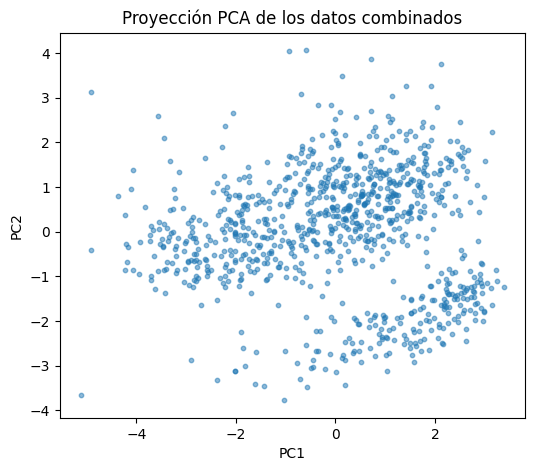

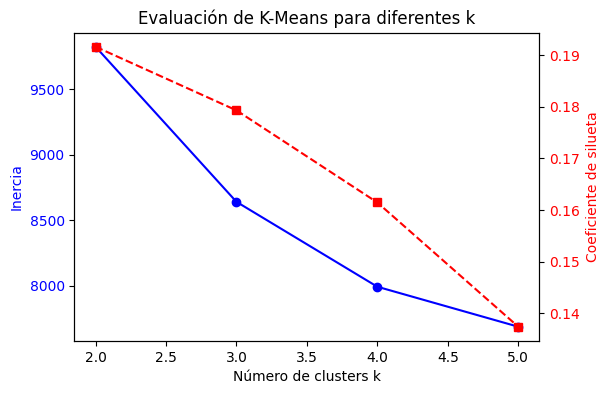

k óptimo según el coeficiente de silueta: 2
Tamaño de cada cluster (K-Means):
cluster_kmeans
0    575
1    341
Name: count, dtype: int64
Perfil medio y mediano por cluster:


age           trestbps               chol         \
                     mean median        mean median        mean median   
cluster_kmeans                                                           
0               58.606957   58.0  135.562141  132.0  176.161687  216.0   
1               44.964809   45.0  126.382090  124.0  223.532353  233.0   

                   thalach          oldpeak        chol_age_ratio            
                      mean median      mean median           mean    median  
cluster_kmeans                                                               
0               128.436433  127.0  1.214451    1.0       3.018713  3.709091  
1               151.405970  152.0  0.351343    0.0       5.044853  5.166538

Distribución de labels por cluster (solo en train):


label,0,1,2,3,4
cluster_kmeans,,,,,
0,129,112,96,92,29
1,198,44,12,15,5


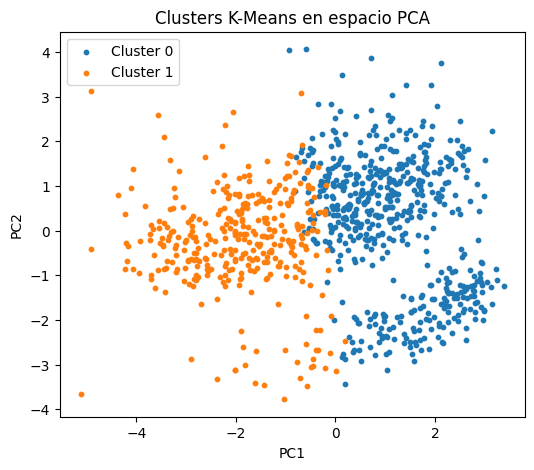

In [12]:

# Prepare data for clustering
def prepare_clustering_data(df_list, drop_cols=None):
    combined = pd.concat(df_list, axis=0, ignore_index=True)
    if drop_cols:
        combined = combined.drop(columns=drop_cols)
    imputer = SimpleImputer(strategy='median')
    scaled = imputer.fit_transform(combined)
    scaler = StandardScaler()
    scaled = scaler.fit_transform(scaled)
    return scaled, combined

scaled_data, combined_df = prepare_clustering_data([
    df_train_clean[numeric_features],
    df_test_clean[numeric_features]
], drop_cols=['ca','thal'])

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)
print(f"Varianza explicada por las dos primeras componentes: {pca.explained_variance_ratio_.sum():.2f}")

plt.figure(figsize=(6,5))
plt.scatter(pca_components[:,0], pca_components[:,1], s=10, alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección PCA de los datos combinados')
plt.show()

# KMeans evaluation
def kmeans_evaluation(data, k_values):
    inertia_list = []
    silhouette_list = []
    for k in k_values:
        km = KMeans(n_clusters=k, random_state=42)
        labels = km.fit_predict(data)
        inertia_list.append(km.inertia_)
        if len(set(labels)) > 1:
            silhouette_list.append(silhouette_score(data, labels))
        else:
            silhouette_list.append(-1)
    return inertia_list, silhouette_list

k_vals = [2,3,4,5]
inertia, silhouettes = kmeans_evaluation(scaled_data, k_vals)

fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(k_vals, inertia, 'o-', color='blue')
ax1.set_xlabel('Número de clusters k')
ax1.set_ylabel('Inercia', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(k_vals, silhouettes, 's--', color='red')
ax2.set_ylabel('Coeficiente de silueta', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('Evaluación de K-Means para diferentes k')
plt.show()

valid_silhouettes = [s if s>=0 else 0 for s in silhouettes]
optimal_k = k_vals[int(np.argmax(valid_silhouettes))]
print(f"k óptimo según el coeficiente de silueta: {optimal_k}")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(scaled_data)

combined_df_kmeans = combined_df.copy()
combined_df_kmeans['cluster_kmeans'] = cluster_labels

cluster_counts = combined_df_kmeans['cluster_kmeans'].value_counts().sort_index()
print("Tamaño de cada cluster (K-Means):")
print(cluster_counts)

profile_vars = ['age','trestbps','chol','thalach','oldpeak','chol_age_ratio']
cluster_profile = combined_df_kmeans.groupby('cluster_kmeans')[profile_vars].agg(['mean','median'])
from IPython.display import display

print("Perfil medio y mediano por cluster:")
display(cluster_profile)

train_clusters = combined_df_kmeans.iloc[:len(df_train_clean)].copy()
train_clusters['label'] = df_train_clean['label'].values
cluster_label_dist = pd.crosstab(train_clusters['cluster_kmeans'], train_clusters['label'])
print("Distribución de labels por cluster (solo en train):")
display(cluster_label_dist)

plt.figure(figsize=(6,5))
for cl in sorted(set(cluster_labels)):
    idx = np.where(cluster_labels == cl)[0]
    plt.scatter(pca_components[idx,0], pca_components[idx,1], s=10, label=f'Cluster {cl}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters K-Means en espacio PCA')
plt.legend()
plt.show()


Resultados de DBSCAN con diferentes parámetros:


,eps,min_samples,n_clusters,n_ruido,silhouette,davies_bouldin,calinski_harabasz
0,0.5,5,0,916,-1.000000,inf,0.000000
1,0.5,10,0,916,-1.000000,inf,0.000000
2,0.8,5,4,896,-0.340378,1.893586,2.505724
3,0.8,10,0,916,-1.000000,inf,0.000000
4,1.0,5,12,837,-0.361207,1.665753,4.438895
5,1.0,10,0,916,-1.000000,inf,0.000000


No se encontraron configuraciones de DBSCAN con silhouette positivo.


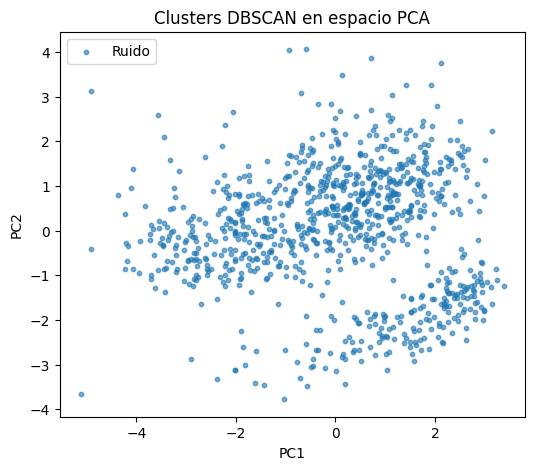

No se formaron clusters densos con DBSCAN.


In [13]:
# DBSCAN evaluation
results_dbscan = []
eps_values = [0.5, 0.8, 1.0]
min_samples_values = [5, 10]
for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels_db = db.fit_predict(scaled_data)
        n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
        n_noise = list(labels_db).count(-1)
        if n_clusters > 1:
            sil = silhouette_score(scaled_data, labels_db)
            dbi = davies_bouldin_score(scaled_data, labels_db)
            chi = calinski_harabasz_score(scaled_data, labels_db)
        else:
            sil = -1
            dbi = np.inf
            chi = 0
        results_dbscan.append({'eps': eps, 'min_samples': ms, 'n_clusters': n_clusters, 'n_ruido': n_noise, 'silhouette': sil, 'davies_bouldin': dbi, 'calinski_harabasz': chi})

results_dbscan_df = pd.DataFrame(results_dbscan)
print("Resultados de DBSCAN con diferentes parámetros:")
from IPython.display import display

display(results_dbscan_df)

valid_dbscan = results_dbscan_df[results_dbscan_df['silhouette'] > 0]
if not valid_dbscan.empty:
    best_db = valid_dbscan.iloc[valid_dbscan['silhouette'].idxmax()]
    best_eps = best_db['eps']
    best_min = best_db['min_samples']
    # En caso de que haya configuraciones válidas, elegir la mejor según la silueta
    print(f"Configuración óptima de DBSCAN: eps={best_eps}, min_samples={best_min}")
    db_best = DBSCAN(eps=best_eps, min_samples=best_min)
    labels_db_best = db_best.fit_predict(scaled_data)
else:
    # Si no hay configuraciones con coeficiente de silueta positivo, marcar todos los puntos como ruido
    labels_db_best = np.full(len(scaled_data), -1)
    print("No se encontraron configuraciones de DBSCAN con silhouette positivo.")

combined_df_dbscan = combined_df.copy()
combined_df_dbscan['cluster_dbscan'] = labels_db_best

plt.figure(figsize=(6,5))
unique_labels = set(labels_db_best)
for cl in unique_labels:
    idx = np.where(labels_db_best == cl)[0]
    if cl == -1:
        label_name = 'Ruido'
        color = 'black'
    else:
        label_name = f'Cluster {cl}'
        color = None
    plt.scatter(pca_components[idx,0], pca_components[idx,1], s=10, label=label_name, alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters DBSCAN en espacio PCA')
plt.legend()
plt.show()

if len(set(labels_db_best)) - (1 if -1 in labels_db_best else 0) > 0:
    db_profile = combined_df_dbscan.groupby('cluster_dbscan')[profile_vars].agg(['mean','median'])
    print("Perfil medio y mediano por cluster (DBSCAN):")
    display(db_profile)
else:
    print("No se formaron clusters densos con DBSCAN.")

## 11. Conclusiones del análisis de clustering

* **K‑means** permitió identificar grupos con perfiles distintos de edad, colesterol y oldpeak; algunos clusters están más asociados a presencia de enfermedad.
* **DBSCAN** no encontró una estructura de densidad clara en los valores probados; la mayoría de puntos resultaron ruido.
* La reducción a dos dimensiones mediante PCA facilitó la visualización pero captura sólo una fracción de la varianza.

El análisis de clustering complementa el modelo supervisado al sugerir subpoblaciones y perfiles de riesgo.


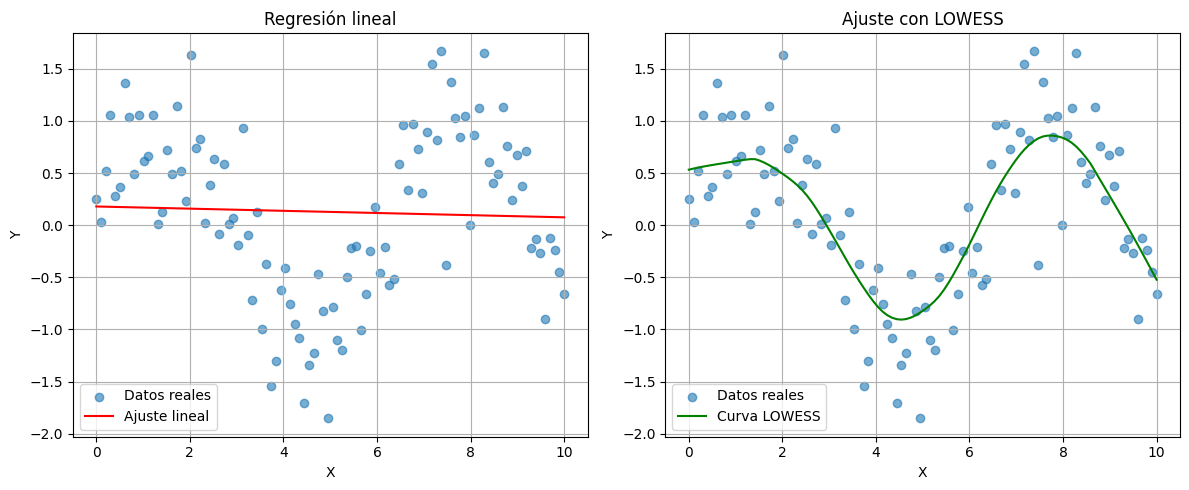

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Crear datos con ruido
np.random.seed(42)
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(scale=0.5, size=x.shape)

# LOWESS
lowess = sm.nonparametric.lowess
y_lowess = lowess(y, x, frac=0.3)

# Gráficos
plt.figure(figsize=(12, 5))

# Gráfico 1: Línea recta
plt.subplot(1, 2, 1)
plt.scatter(x, y, alpha=0.6, label="Datos reales")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), color='red', label='Ajuste lineal')
plt.title("Regresión lineal")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()

# Gráfico 2: LOWESS
plt.subplot(1, 2, 2)
plt.scatter(x, y, alpha=0.6, label="Datos reales")
plt.plot(y_lowess[:, 0], y_lowess[:, 1], color='green', label='Curva LOWESS')
plt.title("Ajuste con LOWESS")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


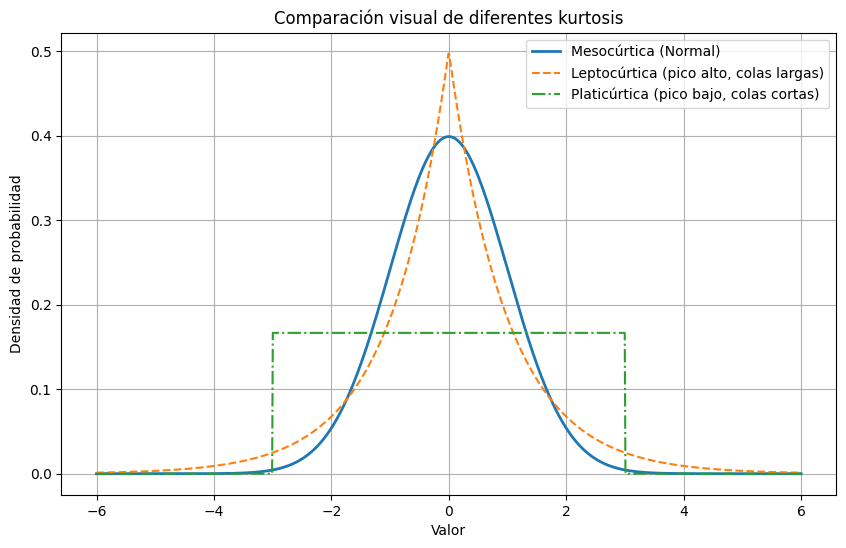

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, laplace, uniform

# Crear rango de valores
x = np.linspace(-6, 6, 1000)

# Diferentes distribuciones
normal = norm.pdf(x)                            # Mesocúrtica: distribución normal
leptokurtic = laplace.pdf(x)                    # Leptocúrtica: colas largas
platikurtic = uniform.pdf(x, loc=-3, scale=6)   # Platicúrtica: más chata

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(x, normal, label="Mesocúrtica (Normal)", linewidth=2)
plt.plot(x, leptokurtic, '--', label="Leptocúrtica (pico alto, colas largas)")
plt.plot(x, platikurtic, '-.', label="Platicúrtica (pico bajo, colas cortas)")
plt.title("Comparación visual de diferentes kurtosis")
plt.xlabel("Valor")
plt.ylabel("Densidad de probabilidad")
plt.legend()
plt.grid(True)
plt.show()
